In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Solver:
    # Игрок, чья стратегия - уменьшение проигрыша
    def __init__(self, bandits_line, eps, init_prob=1.0):
        np.random.seed(int(time.time()))

        self.bandits_line = bandits_line

        self.counts = [0] * self.bandits_line.n
        self.actions = []  # Список выбранных автоматов, от 0 до bandits_line.n-1.
        self.regret = 0.  # Накапливаемый проигрыш.
        self.regrets = [0.]  # Накапливаемый проигрыш в ретроспективе.

        assert 0. <= eps <= 1.0
        self.eps = eps

        self.estimates = [init_prob] * self.bandits_line.n

    def update_regret(self, i):
        # i: индекс выбранного игрового автомата.
        self.regret += self.bandits_line.best_prob - self.bandits_line.probs[i]
        self.regrets.append(self.regret)

    @property
    def estimated_probs(self):
        return self.estimates

    def run(self, num_steps):
        assert self.bandits_line is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)

    def run_one_step(self):
        if np.random.random() < self.eps:
            i = np.random.randint(0, self.bandits_line.n)
        else:
            i = max(range(self.bandits_line.n), key=lambda x: self.estimates[x])

        r = self.bandits_line.generate_reward(i)
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

In [0]:
class BanditsLine:
    # Ряд игровых автоматов с заданной вероятнотью выигрыша
    def __init__(self, n, probs=None):
        assert probs is None or len(probs) == n
        self.n = n
        if probs is None:
            np.random.seed(int(time.time()))
            self.probs = [1 - 2 * np.random.random() for _ in range(self.n)]
        else:
            self.probs = probs

        self.best_bandit = max(range(self.n), key=lambda x: self.probs[x])
        self.best_prob = self.probs[self.best_bandit]

    def create_optimal_bandit(self, i, opt_val):
        # i: индекс оптимального автомата.
        # opt_val: вероятность выигрыша на оптимальном автомате (opv_val > self.best_prob)
        assert opt_val > self.best_prob and opt_val <= 1, "Не удалось создать оптимальный автомат"
        if opt_val > self.best_prob:
            self.probs[i] = opt_val
            self.best_prob = opt_val
            self.best_bandit = i

    def generate_reward(self, i):
        # Игрок выбрал i-й игровой автомат.
        result = 1 - 2 * np.random.random()
        if result < self.probs[i]:
            return 1
        else:
            return -1

In [0]:
def plot_results(s):
    b = s.bandits_line

    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.3, wspace=0.3)

    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    # Sub.fig. 1: Regrets in time.
    ax1.plot(range(len(s.regrets)), s.regrets, label="Solver")

    ax1.set_xlabel('Time step')
    ax1.set_ylabel('Cumulative regret')
    ax1.legend(loc=9, bbox_to_anchor=(1.82, -0.25), ncol=5)
    ax1.grid('k', ls='--', alpha=0.3)

    # Sub.fig. 2: Probabilities estimated by solvers.
    sorted_indices = sorted(range(b.n), key=lambda x: b.probs[x])
    ax2.plot(range(b.n), [b.probs[x] for x in sorted_indices], 'k--', markersize=12)
    
    ax2.plot(range(b.n), [s.estimated_probs[x] for x in sorted_indices], 'x', markeredgewidth=2)
    ax2.set_xlabel('Actions sorted by probs')
    ax2.set_ylabel('Estimated')
    ax2.grid('k', ls='--', alpha=0.3)

    # Sub.fig. 3: Action counts
    ax3.plot(range(b.n), np.array(s.counts) / float(len(s.regrets)), ls='steps', lw=2)
    ax3.set_xlabel('Actions')
    ax3.set_ylabel('Frac. # trials')
    ax3.grid('k', ls='--', alpha=0.3)

    plt.show()

In [0]:
def experiment(k, n):
    # k: количество игровых автоматов.
    # n: количество попыток.

    test_bl = BanditsLine(k)
    print("Случайно сгенерированный ряд игровых автоматов с вероятностями выигрыша:")
    for x in range(k):
        print("\t{}: {}".format(x, test_bl.probs[x]))
    print("Лучший игровой автомат:\n\t{}: {}".format(
        max(range(k), key=lambda x: test_bl.probs[x]), max(test_bl.probs)))

    test_solver = Solver(test_bl, 0.01)
    test_solver.run(n)

    plot_results(test_solver)

In [0]:
def experiment_with_optimal_bandit(k, n, i, opt_val):
    # k: количество игровых автоматов.
    # n: количество попыток.
    # i: индекс оптимального автомата.
    # opt_val: вероятность выигрыша на оптимальном автомате.

    test_bl = BanditsLine(k)
    test_bl.create_optimal_bandit(i, opt_val)
    print("Случайно сгенерированный ряд игровых автоматов с вероятностями выигрыша:")
    for x in range(k):
        print("\t{}: {}".format(x, test_bl.probs[x]))
    print("Оптимальный игровой автомат:\n\t{}: {}".format(i, test_bl.probs[i]))

    test_solver = Solver(test_bl, 0.01)
    test_solver.run(n)

    plot_results(test_solver)

Случайно сгенерированный ряд игровых автоматов с вероятностями выигрыша:
	0: 0.9528911623703216
	1: 0.6789642610950168
	2: -0.6926562154858786
	3: 0.19995664813682734
	4: 1
	5: -0.12952360681045172
	6: -0.8408083237110224
	7: 0.5550271375971019
	8: 0.880985824600667
	9: -0.27380692262365414
Оптимальный игровой автомат:
	4: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


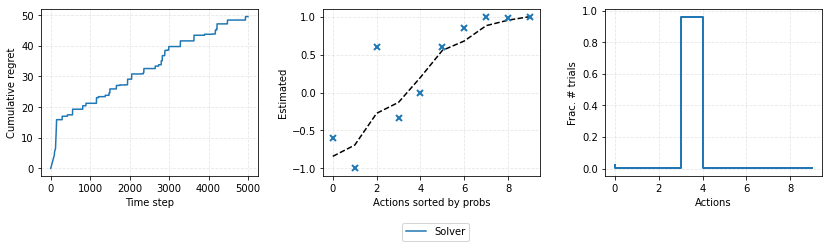

In [7]:
#experiment(10, 5000)
experiment_with_optimal_bandit(10, 5000, 4, 1)